Objective: Handwritten Digit Recognition 

In this assignment, you are asked to design and develop artificial neural network models that can 
classify  handwritten  digits  from  the  MNIST  dataset.  The  MNIST  dataset  consists  of  60,000  
training  images  and  10,000  testing  images.  Each  image  is  a  small  28x28  (784)  pixels  grayscale  
digit between 0 and 9. You can use a Python library to download this dataset. 
 
From  this  assignment,  you  will  also  learn  how  to  process  and  compute  images,  and  design 
multilayer backpropagation perceptron (MLP) and Convolutional Neural Network (CNN) 
architectures.

# Project Setup

## Import relevant libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as AF
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Download the dataset

For this project, we will be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). However, before using the dataset we have to preprocess the data. Specifically, converting the images to tensors and scaling the pixel values from 0-255 down to 0-1.

In [2]:
mini_batch_size = 1000

transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transformer, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transformer, download=False
)

train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=mini_batch_size, shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=mini_batch_size, shuffle=True
)

print(f"Mini batch size: {mini_batch_size}")
print(f"Number of batches loaded for training: {len(train_dataloader)}")
print(f"Number of batches loaded for testing: {len(test_dataloader)}")

Mini batch size: 1000
Number of batches loaded for training: 60
Number of batches loaded for testing: 10


## Visualizing the dataset


In [3]:
# Dataloader that only loads 1 image at a time for the purposes of sampling 
# individual images
sample_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

images, labels = next(iter(sample_dataloader))
print(images.shape)

torch.Size([1, 1, 28, 28])


As we can see, the shape of each image is 28x28, meaning there are 784 inputs for our model. Let's display some of the images from the dataset

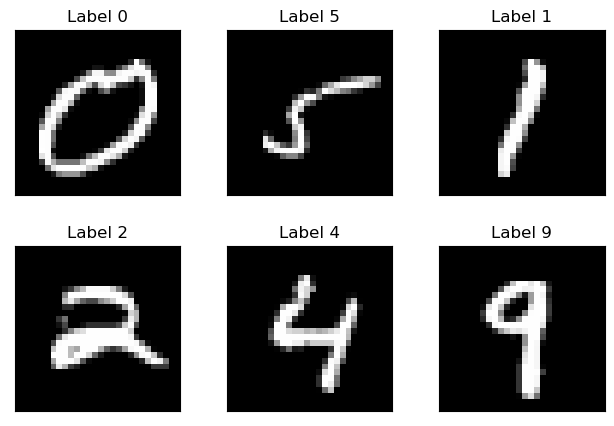

In [4]:
fig = plt.figure()
for i in range(6):
    images, labels = next(iter(sample_dataloader))
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(images[0][0].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f'Label {labels[0]}')
    plt.xticks([])
    plt.yticks([])
    fig

# Part 1: Multi Layer Perceptron (MLP)

## Model Construction

Our MLP model used 4 linear layers for a total of 2330 neurons and the activation function we used was the Rectified Linear Unit (ReLU) with the LogSoftMax activation as the output activation function because this is a classification problem.

In [5]:
model = nn.Sequential(
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
    nn.LogSoftmax(dim=1),
)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


For our loss function we used the Cross Entropy Loss function

In [6]:
loss_function = nn.CrossEntropyLoss()

For our gradient method we used the Adam optimizer with a learning rate of 0.003

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [8]:
import time

time0 = time.perf_counter()
num_epochs = 20

# use gpu if available
device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)
if torch.cuda.is_available():
    print("The CUDA version is", torch.version.cuda)
    cuda_id = torch.cuda.current_device()
    print("ID of the CUDA device:", cuda_id)
    print("The name of the CUDA device:", torch.cuda.get_device_name(cuda_id))

    print("Training with CUDA")
    model = model.to(device=device)

elif device.type == "mps" or device.type == "cuda":
    print("Training with Apple Silicon")
    device = torch.device("mps")
    model = model.to(device)
else:
    print("Training with CPU")

for e in range(num_epochs):
    running_loss = 0
    for images, labels in train_dataloader:
        if device.type == "mps" or device.type == "cuda":
            images = images.to(device)
            labels = labels.to(device)
        images = images.view(images.shape[0], -1)

        # set the cumulated gradient to zero
        optimizer.zero_grad()

        # feedforward images as input to the network
        output = model(images)
        loss = loss_function(output, labels)

        # calculating gradients backward using Autograd
        loss.backward()

        # updating all parameters after every iteration through backpropagation
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Epoch {e} - Training loss: {running_loss / len(train_dataloader)}")
print(f"Training Time: {time.perf_counter() - time0}")

Training with Apple Silicon
Epoch 0 - Training loss: 0.7270428881049156
Epoch 1 - Training loss: 0.18296852745115758
Epoch 2 - Training loss: 0.12096500421563784
Epoch 3 - Training loss: 0.0994065772742033
Epoch 4 - Training loss: 0.08121532642592987
Epoch 5 - Training loss: 0.06551298306634029
Epoch 6 - Training loss: 0.05677496703962485
Epoch 7 - Training loss: 0.04627261282876134
Epoch 8 - Training loss: 0.040531864513953526
Epoch 9 - Training loss: 0.03132925862446427
Epoch 10 - Training loss: 0.028930580724651614
Epoch 11 - Training loss: 0.03912126561626792
Epoch 12 - Training loss: 0.030009797929475706
Epoch 13 - Training loss: 0.028068558204298218
Epoch 14 - Training loss: 0.02887965744982163
Epoch 15 - Training loss: 0.025898890445629756
Epoch 16 - Training loss: 0.01847738018259406
Epoch 17 - Training loss: 0.02205954057474931
Epoch 18 - Training loss: 0.01785524868561576
Epoch 19 - Training loss: 0.01775307717034593
Training Time: 50.249069459000005


In [9]:
# torch.no_grad() is a decorator for the step method
# making "require_grad" false since no need to keeping track of gradients
predicted_digits = []
# torch.no_grad() deactivates Autogra engine (for weight updates)
with torch.no_grad():
    # set the model in testing mode
    model.eval()
    for batch_cnt, (images, labels) in enumerate(test_dataloader):
        images = images.reshape(-1, 784)

        if device.type == "mps" or device.type == "cuda":
            images = images.to(device)
            labels = labels.to(device)

        # returns the max value of all elements in the input tensor
        output = model(images)
        _, prediction = torch.max(output, 1)
        predicted_digits.append(prediction)
        num_samples = labels.shape[0]
        num_correct = (prediction == labels).sum().item()
        accuracy = num_correct / num_samples
    print(f"Number of samples: {num_samples}")
    print(f"Number of correct prediction: {num_correct}")
    print(f"Accuracy: {accuracy}")

Number of samples: 1000
Number of correct prediction: 977
Accuracy: 0.977


## Results
Our MLP model yielded a classification accuracy of 97.7% after 20 epoches and 50 seconds of training

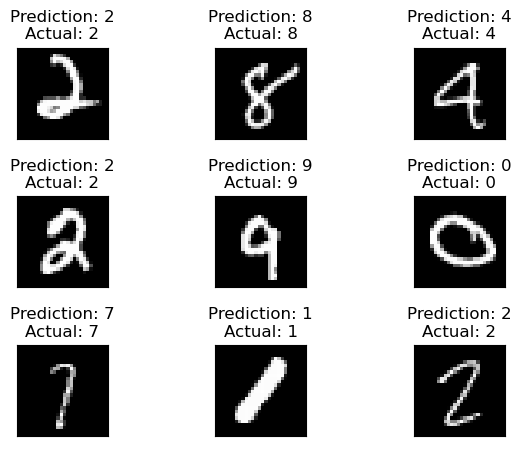

In [10]:
fig = plt.figure()
for i in range(9):
    images, labels = next(iter(sample_dataloader))
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(images[0][0].reshape(28, 28), cmap="gray", interpolation="none")
    images = images.to(device)
    images = images.reshape(-1, 784)
    model.eval()
    output = model(images)
    _, prediction = torch.max(output, 1)
    plt.title(f"Prediction: {prediction[0]}\nActual: {labels[0]}")
    plt.xticks([])
    plt.yticks([])
    fig

As we can see, it tends to correctly classify most digits in the testing set. Let's take a look at what digits it failed to properly classify

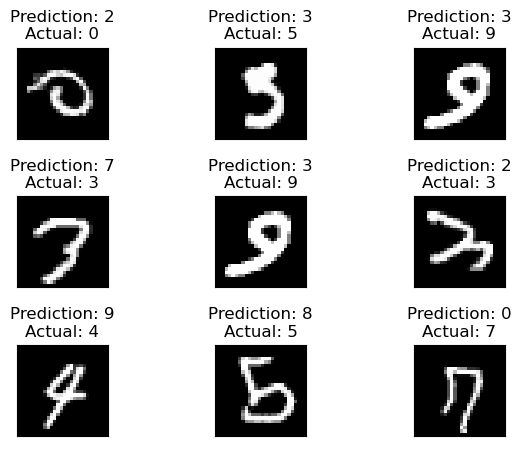

In [11]:
fig = plt.figure()
i = 0
while i < 9:
    images, labels = next(iter(sample_dataloader))
    images_ = images.to(device)
    images_ = images_.reshape(-1, 784)
    model.eval()
    output = model(images_)
    _, prediction = torch.max(output, 1)
    if prediction[0] == labels[0]:
        continue;
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(images[0][0].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f"Prediction: {prediction[0]}\nActual: {labels[0]}")
    plt.xticks([])
    plt.yticks([])
    i = i + 1
    fig

# Part 2: Convolutional Neural Network
## Model Construction

Our CNN model used only 1 Conv2d layer with 1 MaxPool2d layer and an additional hidden linear layer. It uses the ReLU activation function.

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout_conv1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, 10)
        self.hidden = nn.Linear(28 * 13 * 13, 128)
        self.out = nn.ReLU()

    def forward(self, x):
        x = self.out(self.conv1(x))
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.out(self.hidden(x))
        x = self.dropout_conv1(x)
        x = self.fc1(x)
        return x


model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_conv1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
  (hidden): Linear(in_features=4732, out_features=128, bias=True)
  (out): ReLU()
)


Our loss function and optimizer used the same parameters as the MLP model. Cross Entropy Loss and Adam respectively.

In [20]:
loss_function = nn.CrossEntropyLoss()

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [22]:
import time

time0 = time.perf_counter()
num_epochs = 20

# use gpu if available
device = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu"
)
if torch.cuda.is_available():
    print("The CUDA version is", torch.version.cuda)
    cuda_id = torch.cuda.current_device()
    print("ID of the CUDA device:", cuda_id)
    print("The name of the CUDA device:", torch.cuda.get_device_name(cuda_id))

    print("Training with CUDA")
    model = model.to(device=device)

elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    print("Training with Apple Silicon")
    device = torch.device("mps")
    model = model.to(device)
else:
    print("Training with CPU")

for e in range(num_epochs):
    running_loss = 0
    for images, labels in train_dataloader:
        if device.type == "mps" or device.type == "cuda":
            images = images.to(device)
            labels = labels.to(device)

        # set the cumulated gradient to zero
        optimizer.zero_grad()

        # feedforward images as input to the network
        output = model(images)
        loss = loss_function(output, labels)

        # calculating gradients backward using Autograd
        loss.backward()

        # updating all parameters after every iteration through backpropagation
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Epoch {e} - Training loss: {running_loss / len(train_dataloader)}")
print(f"Training Time: {time.perf_counter() - time0}")

Training with Apple Silicon
Epoch 0 - Training loss: 0.7774978816509247
Epoch 1 - Training loss: 0.21060840388139088
Epoch 2 - Training loss: 0.13664192569752534
Epoch 3 - Training loss: 0.10303225591778756
Epoch 4 - Training loss: 0.08371688704937696
Epoch 5 - Training loss: 0.07220698160429796
Epoch 6 - Training loss: 0.06068011938283841
Epoch 7 - Training loss: 0.052955617755651475
Epoch 8 - Training loss: 0.04873626853028933
Epoch 9 - Training loss: 0.04451569048687816
Epoch 10 - Training loss: 0.03952591083943844
Epoch 11 - Training loss: 0.03546929840619365
Epoch 12 - Training loss: 0.03306238213554025
Epoch 13 - Training loss: 0.02939973141377171
Epoch 14 - Training loss: 0.02927619023248553
Epoch 15 - Training loss: 0.02619840088300407
Epoch 16 - Training loss: 0.023921654171620805
Epoch 17 - Training loss: 0.022339363861829043
Epoch 18 - Training loss: 0.021859181796511015
Epoch 19 - Training loss: 0.018781833381702504
Training Time: 72.37322920899999


In [23]:
# torch.no_grad() is a decorator for the step method
# making "require_grad" false since no need to keeping track of gradients
predicted_digits = []
# torch.no_grad() deactivates Autogra engine (for weight updates)
with torch.no_grad():
    # set the model in testing mode
    model.eval()
    for batch_cnt, (images, labels) in enumerate(test_dataloader):
        if device.type == "mps" or device.type == "cuda":
            images = images.to(device)
            labels = labels.to(device)

        # returns the max value of all elements in the input tensor
        output = model(images)
        _, prediction = torch.max(output, 1)
        predicted_digits.append(prediction)
        num_samples = labels.shape[0]
        num_correct = (prediction == labels).sum().item()
        accuracy = num_correct / num_samples
    print(f"Number of samples: {num_samples}")
    print(f"Number of correct prediction: {num_correct}")
    print(f"Accuracy: {accuracy}")

Number of samples: 1000
Number of correct prediction: 992
Accuracy: 0.992


## Results
Our CNN model yielded a classification accuracy of 99.2% after 20 epoches and 72 seconds of training.

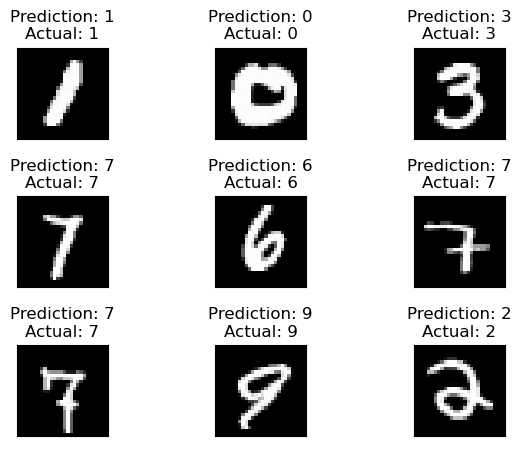

In [24]:
fig = plt.figure()
for i in range(9):
    images, labels = next(iter(sample_dataloader))
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(images[0][0].reshape(28, 28), cmap="gray", interpolation="none")
    images = images.to(device)
    model.eval()
    output = model(images)
    _, prediction = torch.max(output, 1)
    plt.title(f"Prediction: {prediction[0]}\nActual: {labels[0]}")
    plt.xticks([])
    plt.yticks([])
    fig

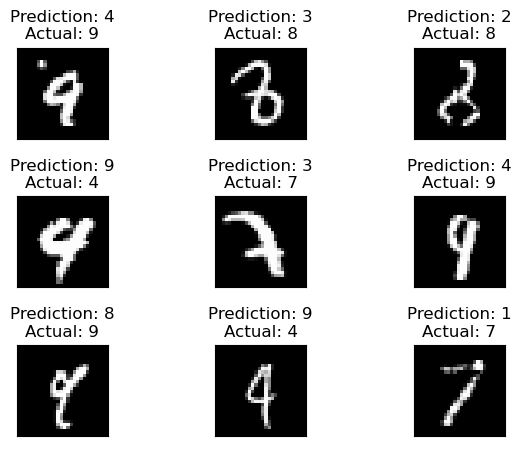

In [28]:
fig = plt.figure()
i = 0
while i < 9:
    images, labels = next(iter(sample_dataloader))
    images_ = images.to(device)
    model.eval()
    output = model(images_)
    _, prediction = torch.max(output, 1)
    if prediction[0] == labels[0]:
        continue;
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(images[0][0].reshape(28, 28), cmap="gray", interpolation="none")
    plt.title(f"Prediction: {prediction[0]}\nActual: {labels[0]}")
    plt.xticks([])
    plt.yticks([])
    i = i + 1
    fig

# Conclusion

We found that the Convolutional Neural Network model consistently out performs the Multi Layer Perceptron model in classification accuracy. However it is worth noting that the MLP model tended to have faster training times despite having more layers than the CNN. As such, we would recommend using a CNN for the classification of hand written digits